<a href="https://colab.research.google.com/github/indrad123/imagecaptioning/blob/main/msc_cnn_rnn_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torchtext==0.6.0
!pip install -U torch==1.12.1
!pip install torch_snippets
!pip install anvil-uplink
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
import anvil.server

anvil.server.connect("server_ONHOQ5GVTN7CMPHKEWWI6EO3-TCIGGD3QE64DT7OK")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Published" as SERVER


In [ ]:
import torch
import torch.nn as nn
# Import the pack_padded_sequence function for handling variable length sequences
from torch.nn.utils.rnn import pack_padded_sequence

# Import the models module from torchvision to load pretrained models
from torchvision import models

# Define a custom Encoder class using a Convolutional Neural Network (CNN)
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()

        # Load a pretrained ResNet-152 model
        resnet = models.resnet152(pretrained=True)

        # Remove the last fully connected (fc) layer of ResNet-152
        modules = list(resnet.children())[:-1] # delete the last fc layer.

        # Create a new sequential model with the modified ResNet-152
        self.resnet = nn.Sequential(*modules)

        # Define a new fully connected layer to map the ResNet output to the desired embedding size
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)

        # Add a batch normalization layer to the output of the fully connected layer
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        """Extract feature vectors from input images."""
        # Disable gradient calculation for the ResNet layers (since they are pretrained)
        with torch.no_grad():
            # Pass the input images through the ResNet model
            features = self.resnet(images)

        # Reshape the output features to (batch_size, -1)
        features = features.reshape(features.size(0), -1)

        # Pass the features through the fully connected layer and batch normalization layer
        features = self.bn(self.linear(features))

        # Return the extracted feature vectors
        return features



In [ ]:
# Define a custom Decoder class using a Recurrent Neural Network (RNN) with LSTM
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()

        # Embedding layer to convert word indices to embeddings
        self.embed = nn.Embedding(vocab_size, embed_size)

        # LSTM layer with specified hidden size, number of layers, and batch_first=True
        # batch_first=True means that the input and output tensors are provided as (batch_size, sequence_length, features)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer to map the hidden state output from LSTM to the vocabulary size
        self.linear = nn.Linear(hidden_size, vocab_size)

        # Maximum sequence length for generated captions
        self.max_seq_length = max_seq_length

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generate captions."""
        # Embed the input captions (convert word indices to embeddings)
        embeddings = self.embed(captions)

        # Concatenate the image features and the embedded captions along the sequence dimension
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        # Pack the padded sequence to handle variable length sequences efficiently
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True)

        # Pass the packed sequence through the LSTM
        outputs, _ = self.lstm(packed)

        # Pass the LSTM outputs through the fully connected layer to get vocabulary scores
        outputs = self.linear(outputs[0])

        # Return the final outputs
        return outputs

    def predict(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []  # List to store the generated word indices
        inputs = features.unsqueeze(1)  # Add sequence dimension to features

        # Generate captions word by word up to max_seq_length
        for i in range(self.max_seq_length):
            # Pass the current inputs and states through the LSTM
            hiddens, states = self.lstm(inputs, states)  # hiddens: (batch_size, 1, hidden_size)

            # Pass the LSTM output through the fully connected layer to get vocabulary scores
            outputs = self.linear(hiddens.squeeze(1))  # outputs: (batch_size, vocab_size)

            # Get the index of the most probable next word
            _, predicted = outputs.max(1)  # predicted: (batch_size)

            # Append the predicted word index to the list of sampled_ids
            sampled_ids.append(predicted)

            # Embed the predicted word and use it as the input for the next time step
            inputs = self.embed(predicted)  # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)  # inputs: (batch_size, 1, embed_size)

        # Stack the list of sampled_ids to create a tensor of shape (batch_size, max_seq_length)
        sampled_ids = torch.stack(sampled_ids, 1)

        # Convert the predicted word indices to strings (captions)
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()  # Convert to numpy array
            sampled_caption = []
            for word_id in sampled_id:
                word = vocab.itos[word_id]  # Get the word from the vocabulary
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)  # Join the words to form the sentence
            sentences.append(sentence)

        # Return the generated sentences
        return sentences


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Function to load an image from the given path and apply transformations if specified
def load_image(image_path, transform=None):
    # Open the image and convert it to RGB mode
    image = Image.open(image_path).convert('RGB')
    # Resize the image to the specified dimensions using Lanczos resampling
    image = image.resize([224, 224], Image.LANCZOS)
    # Apply transformations if provided
    if transform is not None:
        # Apply the transformations and add a batch dimension
        tfm_image = transform(image)[None]
    # Return the original image and the transformed image tensor
    return image, tfm_image

# Decorator to disable gradient calculation during image loading and prediction
@torch.no_grad()
def load_image_and_predict(image_path):
    # Define the image transformation pipeline
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize the image
    ])

    # Load the original image and apply transformations
    org_image, tfm_image = load_image(image_path, transform)

    # Move the transformed image tensor to the specified device (e.g., GPU)
    image_tensor = tfm_image.to(device)

    # Set the encoder and decoder models to evaluation mode
    encoder.eval()
    decoder.eval()

    # Extract features from the image using the encoder
    feature = encoder(image_tensor)

    # Generate a caption for the image using the decoder
    sentence = decoder.predict(feature)[0]

    # Display the original image with the predicted caption as the title
    show(org_image, title=sentence)

    # Return the predicted caption
    return sentence

In [ ]:
# Function to load the model parameters, optimizer state, and epoch from a saved file
def load_model(encoder, decoder, optimizer, file_path):
    # Load the saved model checkpoint
    checkpoint = torch.load(file_path)
    # Load the encoder's state dictionary from the checkpoint
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    # Load the decoder's state dictionary from the checkpoint
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    # Load the optimizer's state dictionary from the checkpoint
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # Return the epoch number stored in the checkpoint
    return checkpoint['epoch']

In [ ]:
import pandas as pd
from torch_snippets import *
# Import the Field class from the torchtext.data module for handling text data
from torchtext.data import Field

# Import the COCO class from the pycocotools.coco module to interact with the COCO dataset
from pycocotools.coco import COCO

# Import defaultdict from the collections module to create dictionaries with default values
from collections import defaultdict

# Define a Field object for processing caption text.
# - sequential=False: Indicates that the data will not be treated as a sequence (though this is unusual for text data).
# - init_token='<start>': A token to signify the start of a sequence.
# - eos_token='<end>': A token to signify the end of a sequence.
captions = Field(sequential=False, init_token='<start>', eos_token='<end>')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COCO Datasets/data_translate.csv')
# Filter the dataset to only include the training set and extract the captions column as a list
all_captions = data[data['train']]['caption'].tolist()

# Tokenize all captions by converting each caption to lowercase and splitting it into words
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]

# Flatten the list of lists (tokens of each caption) into a single list of tokens
all_tokens = [w for sublist in all_tokens for w in sublist]

# Build the vocabulary for the captions Field object using the list of all tokens
captions.build_vocab(all_tokens)


In [ ]:
# Define an empty class named Vocab, which will be used to store vocabulary mappings
class Vocab:
    pass

# Create an instance of the Vocab class
vocab = Vocab()

# Insert the '<pad>' token at the beginning of the list of tokens in the 'itos' (index to string) mapping
# This ensures that the padding token has an index of 0
captions.vocab.itos.insert(0, '<pad>')

# Assign the modified 'itos' list from the captions' vocabulary to the 'vocab' instance
vocab.itos = captions.vocab.itos

# Create the 'stoi' (string to index) mapping for the 'vocab' instance using defaultdict
# If a token is not found in the vocabulary, it will default to the index of '<unk>' (unknown token)
vocab.stoi = defaultdict(lambda: captions.vocab.itos.index('<unk>'))

# Explicitly set the index of the '<pad>' token to 0 in the 'stoi' mapping
vocab.stoi['<pad>'] = 0

# Iterate over the original 'stoi' mapping from the captions' vocabulary
# Increment each index by 1 and assign it to the 'stoi' mapping of the 'vocab' instance
# This shift ensures that the '<pad>' token is at index 0 and all other indices are adjusted accordingly
for s, i in captions.vocab.stoi.items():
    vocab.stoi[s] = i + 1

In [ ]:
# Initialize the encoder and decoder models
encoder_eval = EncoderCNN(256).to(device)
decoder_eval = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)

# Define the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Collect parameters from the decoder and the trainable parts of the encoder
params = list(decoder_eval.parameters()) + list(encoder_eval.linear.parameters()) + list(encoder_eval.bn.parameters())

# Initialize the optimizer with AdamW, using the collected parameters and a learning rate of 1e-3
optimizer_eval = torch.optim.AdamW(params, lr=1e-3)


# Load the model parameters and optimizer state from the checkpoint file
load_model(encoder_eval, decoder_eval, optimizer_eval, '/content/drive/MyDrive/Colab Notebooks/CNN-RNN/checkpoint')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


9

In [ ]:
@torch.no_grad()
def load_image_and_predict_from_file(encoder_eval, decoder_eval, image_path):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])

    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)
    encoder_eval.eval()
    decoder_eval.eval()
    feature = encoder_eval(image_tensor)
    sentence = decoder_eval.predict(feature)[0]
    # show(org_image, title=sentence)
    # Display the original image with the predicted sentence as title
    plt.imshow(org_image)
    plt.title(sentence)
    plt.show()
    return sentence

In [ ]:
from PIL import Image
import io
import base64
# Assuming encoder_eval and decoder_eval are already defined and loaded with your model weights
encoder_eval.to(device)
decoder_eval.to(device)

@anvil.server.callable
def load_image_pred(image_base64):
    try:
        # Decode the base64 string back to bytes
        image_bytes = base64.b64decode(image_base64)

        # Load image from bytes
        org_image = Image.open(io.BytesIO(image_bytes))

        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        # Apply transformations
        tfm_image = transform(org_image).unsqueeze(0)  # Add batch dimension

        # Move the input tensor to the same device as the model
        tfm_image = tfm_image.to(device)

        encoder_eval.eval()
        decoder_eval.eval()

        with torch.no_grad():
            feature = encoder_eval(tfm_image)
            sentence = decoder_eval.predict(feature)[0]

        # Display the original image with the predicted sentence as title
        plt.imshow(org_image)
        plt.title(sentence)
        plt.axis('off')
        plt.show()

        return sentence
    except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
!pip install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16353 sha256=33d75fcaffeccc59b96b5a660ebe49a7d8575d997db5c2f206a53cc70049ce11
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling 

In [ ]:


from googletrans import Translator
@anvil.server.callable
def translate_google_text(text):
  try:
    translator = Translator()
    translated = translator.translate(text, src='id', dest='en').text
    return translated
  except Exception as e:
    print(f"Error: {e}")
    return ''

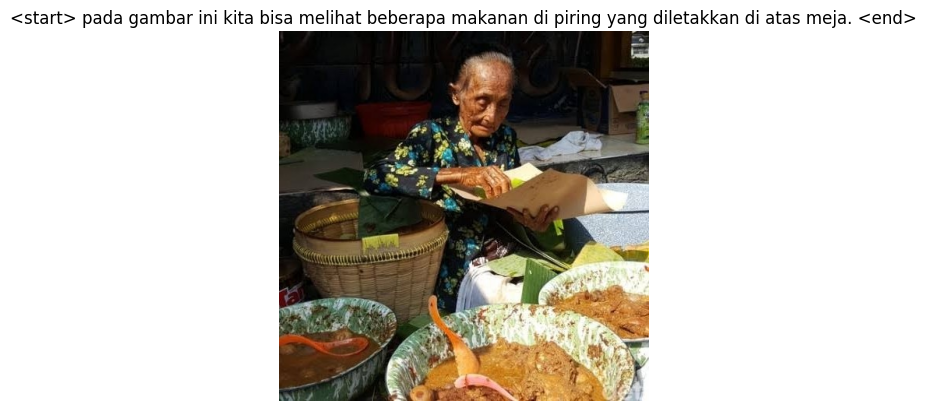

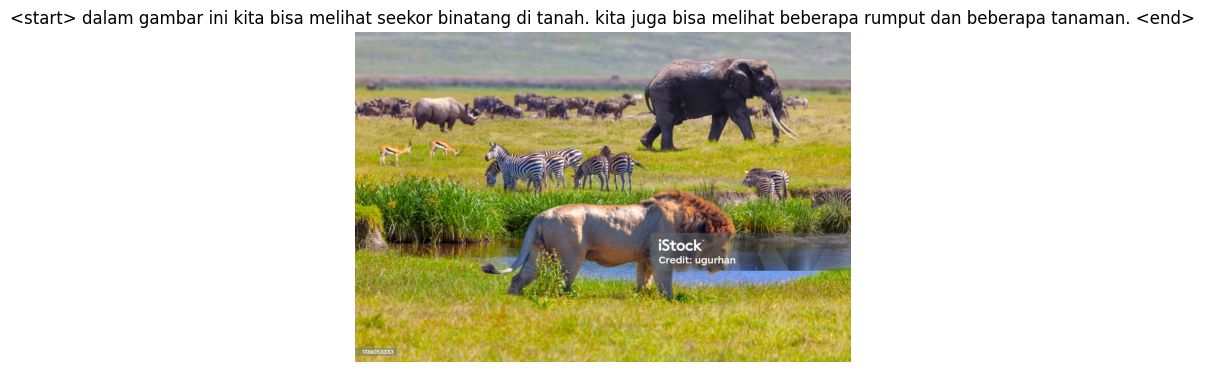

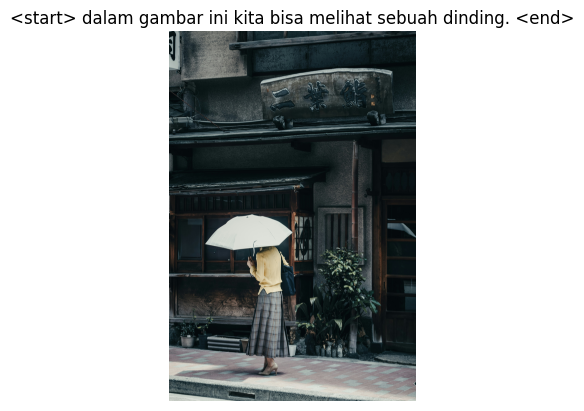

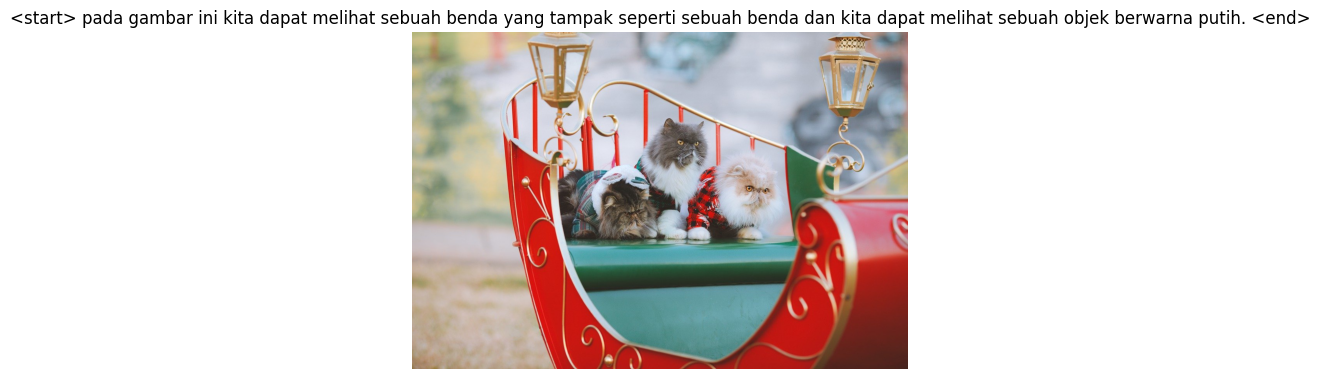

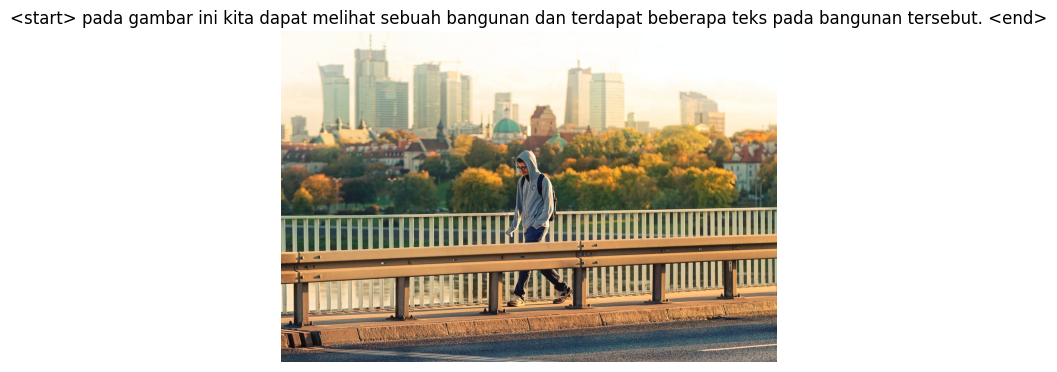

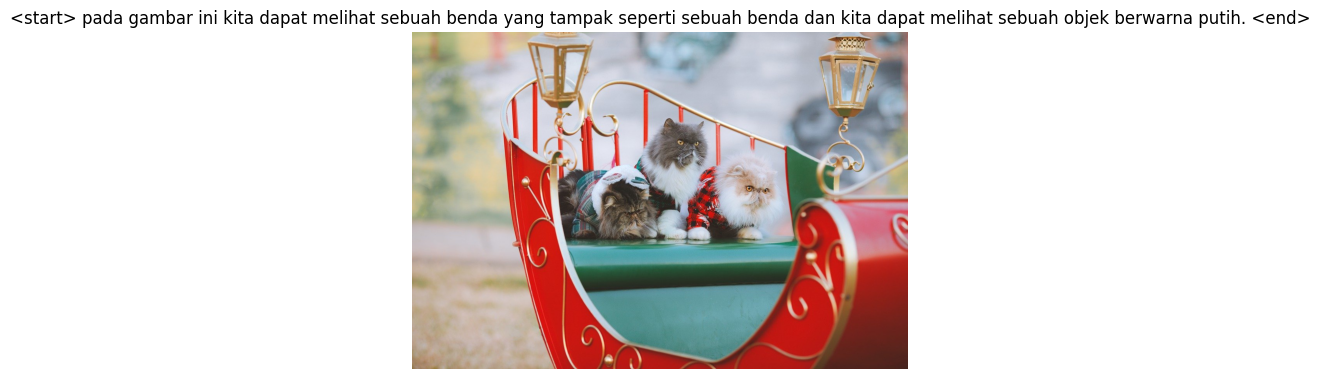

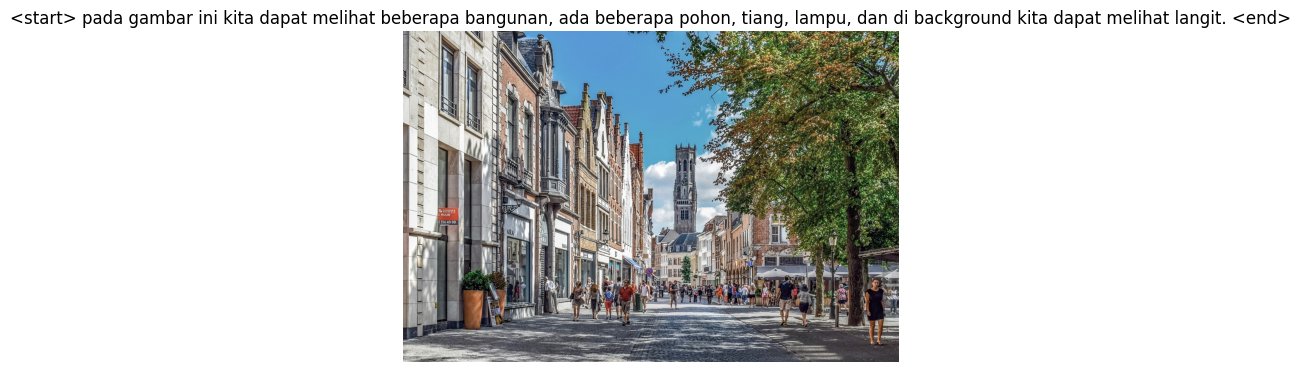

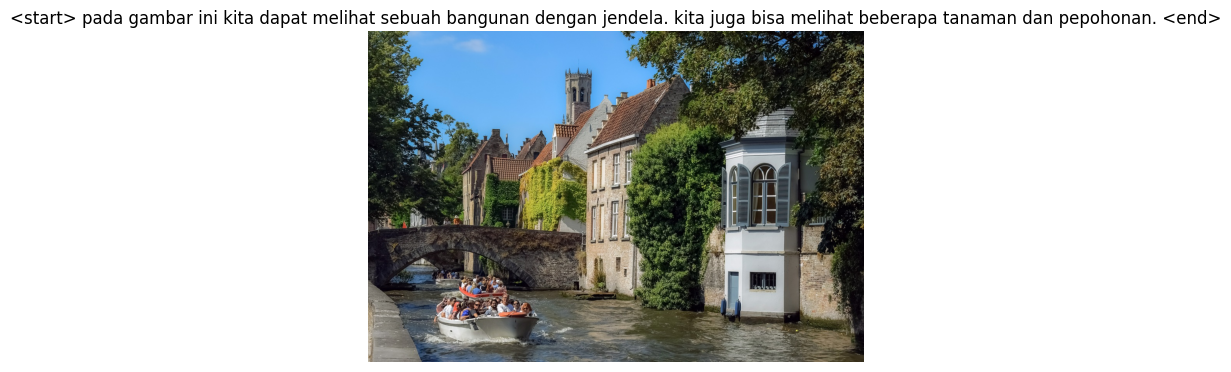

KeyboardInterrupt: 

In [ ]:
anvil.server.wait_forever()

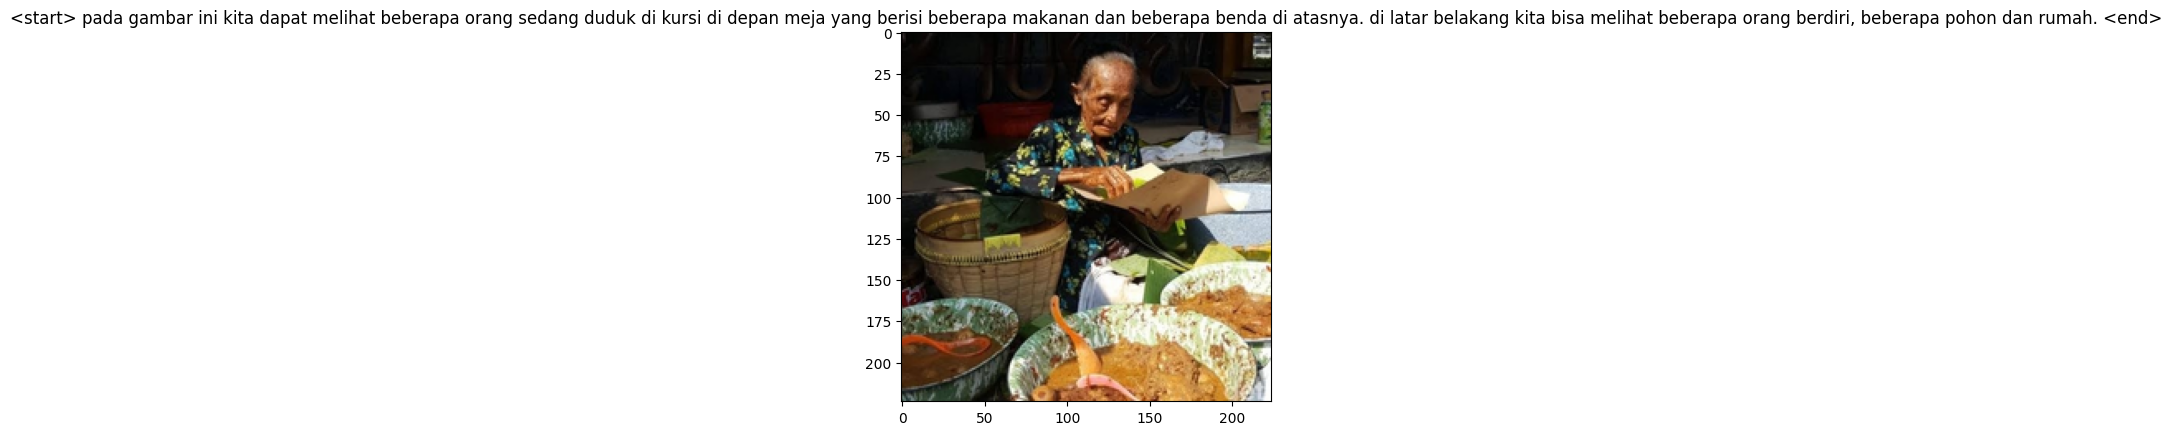

'<start> pada gambar ini kita dapat melihat beberapa orang sedang duduk di kursi di depan meja yang berisi beberapa makanan dan beberapa benda di atasnya. di latar belakang kita bisa melihat beberapa orang berdiri, beberapa pohon dan rumah. <end>'

In [ ]:
text = load_image_and_predict_from_file(encoder_eval, decoder_eval, '/content/drive/MyDrive/Colab Notebooks/Test Data/gudeg.jpeg')
text

In [ ]:
print(text)

<start> pada gambar ini kita dapat melihat beberapa orang sedang duduk di kursi di depan meja yang berisi beberapa makanan dan beberapa benda di atasnya. di latar belakang kita bisa melihat beberapa orang berdiri, beberapa pohon dan rumah. <end>


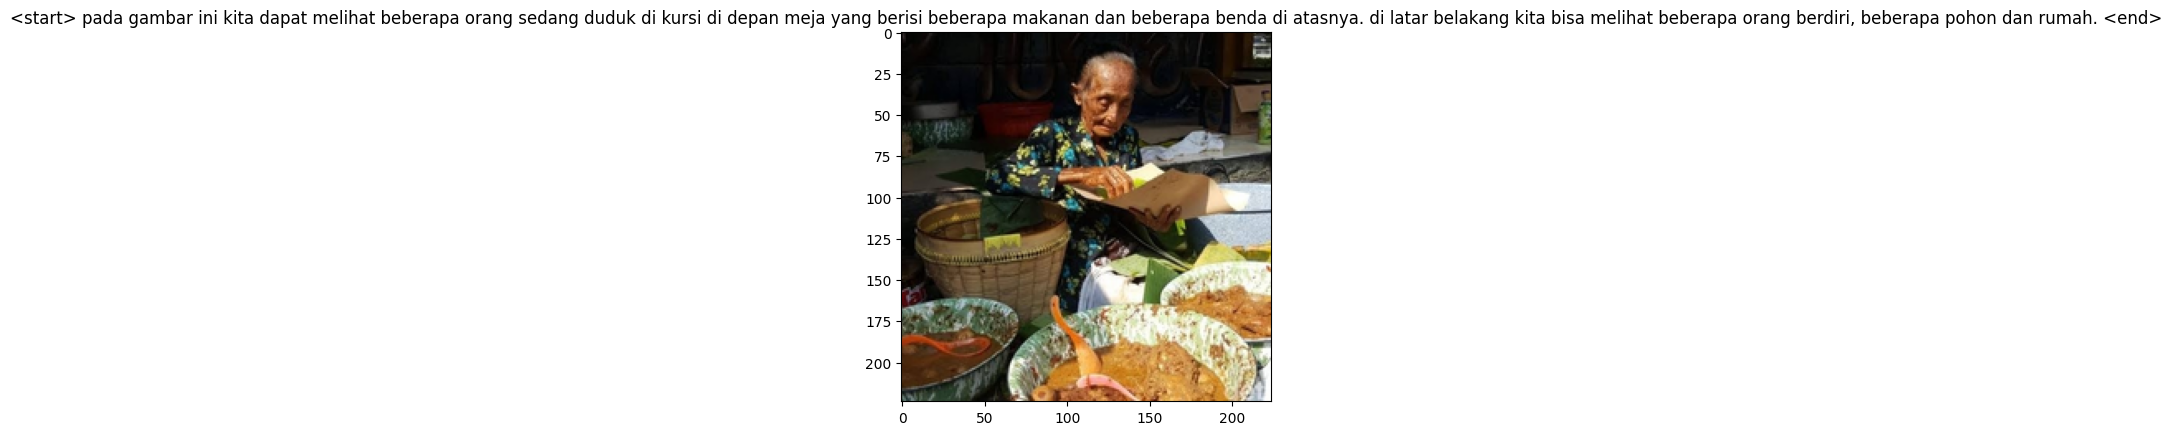

In [ ]:
text = load_image_pred('/content/drive/MyDrive/Colab Notebooks/Test Data/gudeg.jpeg')